Imports aus der Vorlesung genommen (nicht sicher ob wir alles brauchen)

In [1235]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, find_peaks, peak_widths, peak_prominences
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Daten laden

In [1236]:
# Laden aller Daten aus dem Ordner: 'csv_data'
def load_csv_data(folder_name):
    data = {}
    csv_folder = os.path.join(os.getcwd(), folder_name)

    if not os.path.exists(csv_folder):
        print(f"Error: The folder '{csv_folder}' was not found.")
        return data
    
    for file in os.listdir(csv_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_folder, file)
            try:
                filename = file.replace('.csv', '')
                data[filename] = pd.read_csv(file_path, delimiter=',')
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return data


In [1237]:
data = load_csv_data('csv_data')
print(data.keys())

try:
    jump_acc = data['Linear_Acceleration_Jump']
    jump_gyr = data['Gyroscope_Jump']
    squat_acc = data['Linear_Acceleration_Squat']
    squat_gyr = data['Gyroscope_Squat']
except KeyError as e:
    print(f"Key not found: {e}")


dict_keys(['Gyroscope_Jump', 'Gyroscope_Squat', 'Linear_Acceleration_Jump', 'Linear_Acceleration_Squat'])


In [1238]:
print("Jump Accelerometer Data:")
print(jump_acc.describe())


Jump Accelerometer Data:
          Time (s)  Linear Acceleration x (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.022010                       0.704642   
std       2.889770                       0.986032   
min       0.024174                      -3.810173   
25%       2.522923                       0.174252   
50%       5.022130                       0.753718   
75%       7.520972                       1.301103   
max      10.019233                       3.623628   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                    1001.000000                    1001.000000  
mean                        0.177169                       0.349645  
std                        12.297720                       2.986639  
min                       -15.460706                      -7.029371  
25%                        -9.752974                      -1.630308  
50%                        -4.991462                       0.126350  
75%    

In [1239]:
print("Jump Gyroscope Data:")
print(jump_gyr.describe())


Jump Gyroscope Data:
          Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  1001.000000          1001.000000          1001.000000   
mean      5.012072            -0.005314             0.001743   
std       2.889771             0.458255             0.218534   
min       0.014226            -1.205879            -0.704140   
25%       2.512944            -0.306264            -0.132625   
50%       5.012181            -0.035154             0.003196   
75%       7.511023             0.249805             0.128897   
max      10.009284             1.778992             0.759001   

       Gyroscope z (rad/s)  
count          1001.000000  
mean              0.009130  
std               0.251720  
min              -0.725978  
25%              -0.159790  
50%              -0.007457  
75%               0.160322  
max               0.805873  


In [1240]:
print("Squat Accelerometer Data:")
print(squat_acc.describe())

Squat Accelerometer Data:
          Time (s)  Linear Acceleration x (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.021009                      -0.052273   
std       2.888940                       0.419312   
min       0.024449                      -1.476752   
25%       2.522863                      -0.351800   
50%       5.020909                      -0.016270   
75%       7.519170                       0.274177   
max      10.017594                       1.061080   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                    1001.000000                    1001.000000  
mean                       -0.145584                       0.492045  
std                         2.907487                       1.188965  
min                        -5.593678                      -2.324644  
25%                        -2.631484                      -0.373079  
50%                        -0.219042                       0.194327  
75%   

In [1241]:
print("Squat Gyroscope Data:")
print(squat_gyr.describe())

Squat Gyroscope Data:
          Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  1001.000000          1001.000000          1001.000000   
mean      5.011073            -0.051974             0.018884   
std       2.888941             0.559377             0.105692   
min       0.014470            -1.126517            -0.259925   
25%       2.512914            -0.499609            -0.052731   
50%       5.010961            -0.075634             0.021838   
75%       7.509221             0.483097             0.084156   
max      10.007646             0.978978             0.308927   

       Gyroscope z (rad/s)  
count          1001.000000  
mean             -0.002028  
std               0.141957  
min              -0.561394  
25%              -0.095874  
50%               0.004261  
75%               0.090015  
max               0.399474  


In [1242]:
def trim_dataframes_to_shortest(df_list):
    # Bestimmen der minimalen Länge aller DataFrames in der Liste
    min_length = min(df.shape[0] for df in df_list)

    # Kürzen aller DataFrames auf die minimale Länge
    trimmed_dfs = [df.iloc[:min_length] for df in df_list]

    return trimmed_dfs

In [1243]:
jump_acc, jump_gyr, squat_acc, squat_gyr = trim_dataframes_to_shortest([jump_acc, jump_gyr, squat_acc, squat_gyr])

In [1244]:
jump_acc.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.022010,0.704642,0.177169,0.349645
std,2.889770,0.986032,12.297720,2.986639
min,0.024174,-3.810173,-15.460706,-7.029371
25%,2.522923,0.174252,-9.752974,-1.630308
50%,5.022130,0.753718,-4.991462,0.126350
75%,7.520972,1.301103,10.097296,1.730946
max,10.019233,3.623628,31.554523,10.272612


In [1245]:
jump_gyr.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.012072,-0.005314,0.001743,0.009130
std,2.889771,0.458255,0.218534,0.251720
min,0.014226,-1.205879,-0.704140,-0.725978
25%,2.512944,-0.306264,-0.132625,-0.159790
50%,5.012181,-0.035154,0.003196,-0.007457
75%,7.511023,0.249805,0.128897,0.160322
max,10.009284,1.778992,0.759001,0.805873


Funktion zum Plotten

In [1246]:
def compare_acc_gyr(acc_df,gyr_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration x (m/s^2)'], name='Accel X'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope y (rad/s)'], marker=dict(size=4), name='Gyr Y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope z (rad/s)'], marker=dict(size=4), name='Gyr Z'), row=2, col=1)

    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [1247]:
compare_acc_gyr(jump_acc,jump_gyr)

In [1248]:
compare_acc_gyr(squat_acc,squat_gyr)

### Relevante Spalten extrahieren

In [1249]:
print(jump_acc.describe())

          Time (s)  Linear Acceleration x (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.022010                       0.704642   
std       2.889770                       0.986032   
min       0.024174                      -3.810173   
25%       2.522923                       0.174252   
50%       5.022130                       0.753718   
75%       7.520972                       1.301103   
max      10.019233                       3.623628   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                    1001.000000                    1001.000000  
mean                        0.177169                       0.349645  
std                        12.297720                       2.986639  
min                       -15.460706                      -7.029371  
25%                        -9.752974                      -1.630308  
50%                        -4.991462                       0.126350  
75%                        10.09

In [1250]:
print(jump_gyr.describe())

          Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  1001.000000          1001.000000          1001.000000   
mean      5.012072            -0.005314             0.001743   
std       2.889771             0.458255             0.218534   
min       0.014226            -1.205879            -0.704140   
25%       2.512944            -0.306264            -0.132625   
50%       5.012181            -0.035154             0.003196   
75%       7.511023             0.249805             0.128897   
max      10.009284             1.778992             0.759001   

       Gyroscope z (rad/s)  
count          1001.000000  
mean              0.009130  
std               0.251720  
min              -0.725978  
25%              -0.159790  
50%              -0.007457  
75%               0.160322  
max               0.805873  


In [1251]:
def combine_relevant_columns(acc_df, gyr_df):
    linear_acc_z = acc_df['Linear Acceleration z (m/s^2)']
    linear_acc_y = acc_df['Linear Acceleration y (m/s^2)']

    gyroskop_x = gyr_df['Gyroscope x (rad/s)']

    time = gyr_df['Time (s)']

    return pd.DataFrame({
        'Time (s)': time,
        'Linear Acceleration z (m/s^2)': linear_acc_z,
        'Linear Acceleration y (m/s^2)': linear_acc_y,
        'Gyroscope x (rad/s)': gyroskop_x
    })

In [1252]:
combined_df = combine_relevant_columns(jump_acc, jump_gyr)
print(combined_df.head())
print(combined_df.describe())

   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014226                       0.144290                       3.237493   
1  0.024235                       0.156283                       5.267785   
2  0.034215                       0.125469                       7.098951   
3  0.044224                       0.590331                       8.608967   
4  0.054204                       1.138354                       9.717705   

   Gyroscope x (rad/s)  
0            -0.114516  
1            -0.114516  
2            -0.114516  
3            -0.114516  
4            -0.114516  
          Time (s)  Linear Acceleration z (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.012072                       0.349645   
std       2.889771                       2.986639   
min       0.014226                      -7.029371   
25%       2.512944                      -1.630308   
50%       5.012181                       0.126350   
75%       7.5110

In [1253]:
print(combined_df.describe())


          Time (s)  Linear Acceleration z (m/s^2)  \
count  1001.000000                    1001.000000   
mean      5.012072                       0.349645   
std       2.889771                       2.986639   
min       0.014226                      -7.029371   
25%       2.512944                      -1.630308   
50%       5.012181                       0.126350   
75%       7.511023                       1.730946   
max      10.009284                      10.272612   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                    1001.000000          1001.000000  
mean                        0.177169            -0.005314  
std                        12.297720             0.458255  
min                       -15.460706            -1.205879  
25%                        -9.752974            -0.306264  
50%                        -4.991462            -0.035154  
75%                        10.097296             0.249805  
max                        31.554523      

In [1254]:
jump_df = combine_relevant_columns(jump_acc, jump_gyr)

In [1255]:
squat_df = combine_relevant_columns(squat_acc, squat_gyr)

In [1256]:
def plot_frequencies(dataframe):
    plt.figure(figsize=(15, 5))

    filtered_df = dataframe.drop(columns=['Time (s)'])
    num_columns = len(filtered_df.columns)

    for i, column in enumerate(filtered_df.columns, 1):
        dataframe_col = filtered_df[column]
        dft = np.fft.fft(dataframe_col)
        frequencies = np.fft.fftfreq(len(dataframe_col))
        amplitudes = np.abs(dft)

        # Normalisierung der Amplituden
        max_amplitude = np.max(amplitudes)
        normalized_amplitudes = amplitudes / max_amplitude

        # Filtern für positive Frequenzen
        positive_indices = np.where(frequencies > 0)
        positive_frequencies = frequencies[positive_indices]
        positive_normalized_amplitudes = normalized_amplitudes[positive_indices]

        # Erstellen der Subplots
        plt.subplot(1, num_columns, i)
        plt.plot(positive_frequencies, positive_normalized_amplitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Normalized Amplitude')
        plt.title(f"Frequency {column}")

    plt.tight_layout()
    plt.show()

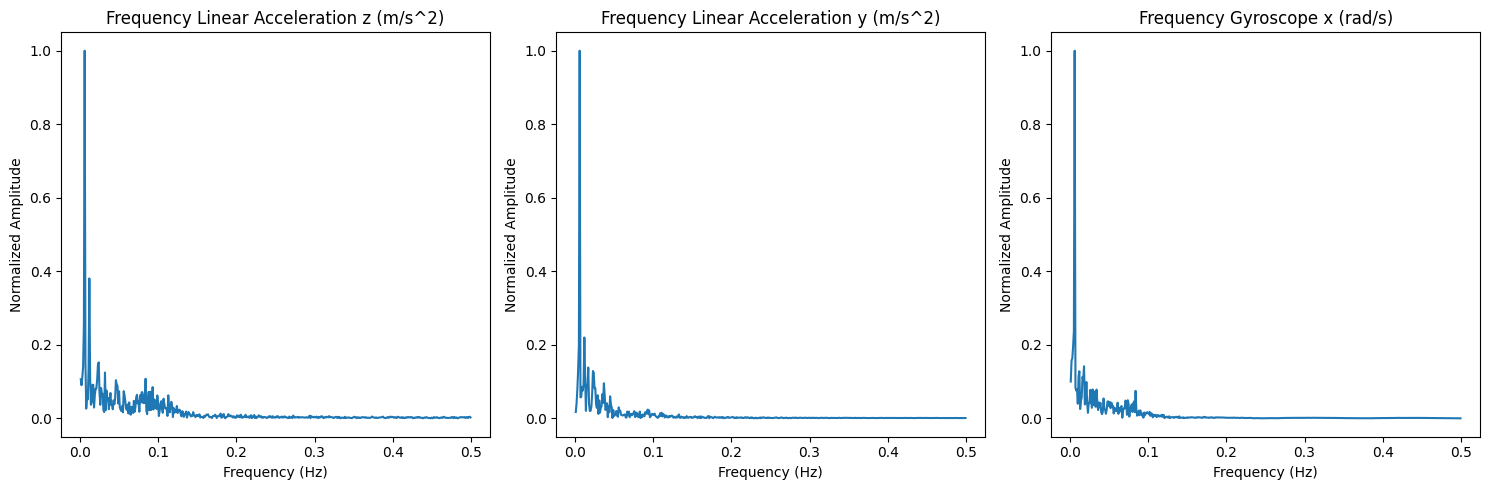

In [1257]:
plot_frequencies(squat_df)

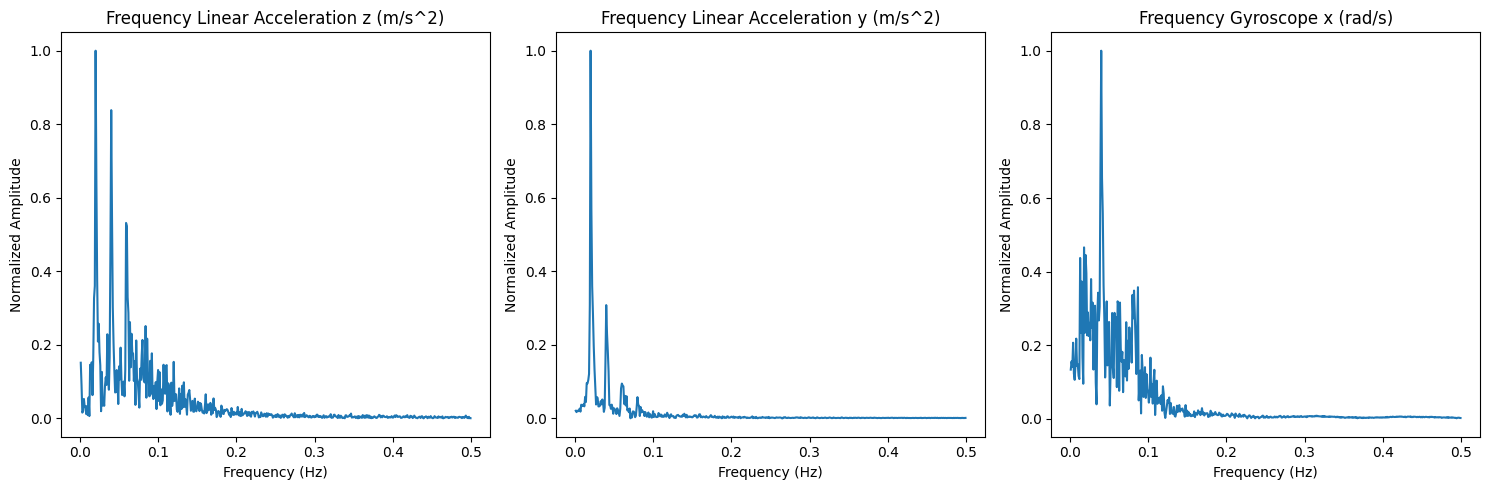

In [1258]:
plot_frequencies(jump_df)

### Filtern der Frequenzen

In [1259]:
def filter_frequency(dataframe):
    # Kopie des DataFrames erstellen
    filtered_dataframe = dataframe.copy()

    # Festlegen der Cutoff-Frequenz und der Filterordnung
    filter_order = 5
    low_cutoff = 5

    # Butterworth Tiefpass erstellen
    b, a = butter(filter_order, low_cutoff, btype='low', analog=False, fs=100)

    # Schleife über alle Spalten außer 'Time (s)'
    for column in dataframe.columns:
        if column != 'Time (s)':
            # Hochpassfilter auf die Signalreihe anwenden
            filtered_signal = filtfilt(b, a, dataframe[column])
            filtered_dataframe[column] = filtered_signal

    return filtered_dataframe

In [1260]:
filtered_df_sq = filter_frequency(squat_df)

In [1261]:
filtered_df_j = filter_frequency(jump_df)

In [1262]:
def plot_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [1263]:
def plot_normal_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Y'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Z'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Gyr_X'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

Frequenz gefiltert

In [1264]:
plot_df(filtered_df_j)

In [1265]:
plot_df(filtered_df_sq)

In [1266]:
filtered_df_j_z = filtered_df_j.copy()
# Korrekte Spaltennamen verwenden
filtered_df_j_z['Z_Score_Y'] = stats.zscore(filtered_df_j['Linear Acceleration y (m/s^2)'])
filtered_df_j_z['Z_Score_Z'] = stats.zscore(filtered_df_j['Linear Acceleration z (m/s^2)'])
filtered_df_j_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_j['Gyroscope x (rad/s)']) 
print(filtered_df_j_z.head())

# Schwellenwert definieren
z_score_threshold = 3

# Ausreißer filtern
filtered_df_j_z = filtered_df_j_z[(abs(filtered_df_j_z['Z_Score_Gyr_X']) <= z_score_threshold) &
                                  (abs(filtered_df_j_z['Z_Score_Y']) <= z_score_threshold) &
                                  (abs(filtered_df_j_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014226                       0.136824                       3.114243   
1  0.024235                       0.355450                       4.933755   
2  0.034215                       0.569090                       6.676340   
3  0.044224                       0.777376                       8.258205   
4  0.054204                       0.980597                       9.604332   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0            -0.103134   0.245389  -0.091113      -0.276149  
1             0.021408   0.397456   0.002355       0.070506  
2             0.140580   0.543094   0.093692       0.402216  
3             0.249445   0.675299   0.182739       0.705238  
4             0.343062   0.787803   0.269621       0.965815  


In [1267]:
filtered_df_sq_z = filtered_df_sq.copy()
# Korrekte Spaltennamen verwenden
filtered_df_sq_z['Z_Score_Y'] = stats.zscore(filtered_df_sq['Linear Acceleration y (m/s^2)'])
filtered_df_sq_z['Z_Score_Z'] = stats.zscore(filtered_df_sq['Linear Acceleration z (m/s^2)'])
filtered_df_sq_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_sq['Gyroscope x (rad/s)']) 
print(filtered_df_sq_z.head())

# Schwellenwert definieren
z_score_threshold = 3

# Ausreißer filtern
filtered_df_sq_z = filtered_df_sq_z[(abs(filtered_df_sq_z['Z_Score_Gyr_X']) <= z_score_threshold) &
                                  (abs(filtered_df_sq_z['Z_Score_Y']) <= z_score_threshold) &
                                  (abs(filtered_df_sq_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014470                      -0.004441                       0.000686   
1  0.024510                       0.054054                      -0.020017   
2  0.034490                       0.109937                      -0.038632   
3  0.044499                       0.160366                      -0.053679   
4  0.054448                       0.202856                      -0.063977   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0            -0.459707   0.050275  -0.440070      -0.742457  
1            -0.432533   0.043112  -0.388275      -0.692976  
2            -0.403966   0.036671  -0.338793      -0.640958  
3            -0.373089   0.031465  -0.294139      -0.584734  
4            -0.339311   0.027902  -0.256516      -0.523228  


Außreißer gefiltert

In [1268]:
plot_normal_df(filtered_df_sq_z)

In [1269]:
plot_normal_df(filtered_df_j_z)

In [1270]:
filtered_df_sq_z['Label'] = 'squat'
filtered_df_j_z['Label'] = 'jump'

In [1271]:
def plot_peaks(df, peaks):
    # Berechnung der Abstände zwischen aufeinanderfolgenden Peaks
    distances = np.diff(peaks)
    # Finden des größten Abstands
    max_distance_idx = np.argmax(distances)
    peak1 = peaks[max_distance_idx]
    peak2 = peaks[max_distance_idx + 1]

    # Erstellen des Plots
    fig = go.Figure()

    # Hinzufügen der Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Y'], mode='lines', name='Accel Y'))

    # Hervorheben der Peaks
    fig.add_trace(go.Scatter(x=df['Time (s)'].iloc[peaks], y=df['Z_Score_Y'].iloc[peaks], mode='markers', marker=dict(size=10, color='red'), name='Peaks'))

    # Zeichnen der Linie für den größten Abstand
    fig.add_trace(go.Scatter(x=[df['Time (s)'].iloc[peak1], df['Time (s)'].iloc[peak2]], 
                             y=[df['Z_Score_Y'].iloc[peak1], df['Z_Score_Y'].iloc[peak2]], 
                             mode='lines', 
                             line=dict(color='blue', width=2, dash='dash'),
                             name='Größter Abstand'))

    # Aktualisiere Layout und Labels
    fig.update_layout(
        title='Accelerometer Daten mit Peaks und größtem Abstand',
        xaxis_title='Zeit (s)',
        yaxis_title='Z-Score Accel Y',
        legend_title='Legende',
        height=600, width=800
    )

    fig.show()


In [1272]:
j_peaks, _ = find_peaks(filtered_df_j_z['Z_Score_Y'], prominence=2)

peak_distances = np.diff(j_peaks)

j_max_distance = np.max(peak_distances)

plot_peaks(filtered_df_j_z, j_peaks)

In [1273]:
sq_peaks, _ = find_peaks(filtered_df_sq_z['Z_Score_Y'], prominence=2, height=1)

peak_distances = np.diff(sq_peaks)

sq_max_distance = np.max(peak_distances)

# Peaks für Kniebeugen plotten
plot_peaks(filtered_df_sq_z, sq_peaks)




In [1274]:
def create_windows_for_df(df, window_size):
    num_windows = df.shape[0] // window_size

    # Leere Liste für die Fenster erstellen
    windows = []

    # Schleife über alle Fenster
    for i in range(num_windows):
        # Start- und Endindex des Fensters
        start_index = i * window_size
        end_index = start_index + window_size

        # Fenster erstellen
        window = df.iloc[start_index:end_index]

        # Fenster zur Liste hinzufügen
        windows.append(window)

    return windows


In [1275]:
create_windows_for_df(filtered_df_sq_z, sq_max_distance)

[     Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
 0    0.014470                      -0.004441                       0.000686   
 1    0.024510                       0.054054                      -0.020017   
 2    0.034490                       0.109937                      -0.038632   
 3    0.044499                       0.160366                      -0.053679   
 4    0.054448                       0.202856                      -0.063977   
 ..        ...                            ...                            ...   
 185  1.863591                       0.485899                      -0.048824   
 186  1.873540                       0.471205                      -0.186940   
 187  1.883580                       0.464156                      -0.337342   
 188  1.893560                       0.461849                      -0.500470   
 189  1.903569                       0.460933                      -0.676018   
 
      Gyroscope x (rad/s)  Z_Score_Y  

In [1276]:

max_time_squat = filtered_df_sq_z['Time (s)'].max()
filtered_df_j_z['Time (s)'] = filtered_df_j_z['Time (s)'] + max_time_squat

# combined_df = pd.concat([filtered_df_sq_z, filtered_df_j_z], ignore_index=True)


In [1277]:
combined_df.tail()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s)
996,9.969306,-0.474950,-7.415934,-0.197607
997,9.979316,-0.514274,-9.340929,-0.093211
998,9.989295,-0.687680,-10.898175,0.016512
999,9.999335,-1.075249,-12.120813,0.117179
1000,10.009284,-1.503227,-12.891053,0.186421


In [1278]:
combined_df.describe()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.012072,0.349645,0.177169,-0.005314
std,2.889771,2.986639,12.297720,0.458255
min,0.014226,-7.029371,-15.460706,-1.205879
25%,2.512944,-1.630308,-9.752974,-0.306264
50%,5.012181,0.126350,-4.991462,-0.035154
75%,7.511023,1.730946,10.097296,0.249805
max,10.009284,10.272612,31.554523,1.778992


In [1279]:
plot_normal_df(combined_df)

KeyError: 'Z_Score_Y'

In [ ]:
combined_df.head()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Z_Score_Y,Z_Score_Z,Z_Score_Gyr_X,Label
0,0.014470,-0.004441,0.000686,-0.459707,0.050275,-0.440070,-0.742457,squat
1,0.024510,0.054054,-0.020017,-0.432533,0.043112,-0.388275,-0.692976,squat
2,0.034490,0.109937,-0.038632,-0.403966,0.036671,-0.338793,-0.640958,squat
3,0.044499,0.160366,-0.053679,-0.373089,0.031465,-0.294139,-0.584734,squat
4,0.054448,0.202856,-0.063977,-0.339311,0.027902,-0.256516,-0.523228,squat


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014470                      -0.004441                       0.000686   
1  0.024510                       0.054054                      -0.020017   
2  0.034490                       0.109937                      -0.038632   
3  0.044499                       0.160366                      -0.053679   
4  0.054448                       0.202856                      -0.063977   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  Label  
0            -0.459707   0.050275  -0.440070      -0.742457  squat  
1            -0.432533   0.043112  -0.388275      -0.692976  squat  
2            -0.403966   0.036671  -0.338793      -0.640958  squat  
3            -0.373089   0.031465  -0.294139      -0.584734  squat  
4            -0.339311   0.027902  -0.256516      -0.523228  squat  
100
40


In [ ]:
windows[0].head()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Z_Score_Y,Z_Score_Z,Z_Score_Gyr_X,Label
0,0.014470,-0.004441,0.000686,-0.459707,0.050275,-0.440070,-0.742457,squat
1,0.024510,0.054054,-0.020017,-0.432533,0.043112,-0.388275,-0.692976,squat
2,0.034490,0.109937,-0.038632,-0.403966,0.036671,-0.338793,-0.640958,squat
3,0.044499,0.160366,-0.053679,-0.373089,0.031465,-0.294139,-0.584734,squat
4,0.054448,0.202856,-0.063977,-0.339311,0.027902,-0.256516,-0.523228,squat


In [ ]:
# Leere Liste erstellen, um Features zu speichern
feature_list = []

# Jeden DataFrame in windows einzeln durchgehen und für jede der drei Achsen die Features berechnen
for window in windows:
    acc_y = window['Z_Score_Y']
    acc_z = window['Z_Score_Z']
    gyro_x = window['Z_Score_Gyr_X']

    # Berechnete Werte an Liste anhängen, unter entsprechend benannten Spalten
    features = {
        'acc_y_peak': acc_y.max(),
        'acc_y_std_dev': acc_y.std(),
        'acc_y_variance': acc_y.var(),
        'acc_y_signal_energy': np.sum(acc_y**2),
        'acc_z_peak': acc_z.max(),
        'acc_z_std_dev': acc_z.std(),
        'acc_z_variance': acc_z.var(),
        'acc_z_signal_energy': np.sum(acc_z**2),
        'gyro_x_peak': gyro_x.max(),
        'gyro_x_std_dev': gyro_x.std(),
        'gyro_x_variance': gyro_x.var(),
        'gyro_x_signal_energy': np.sum(gyro_x**2)
    }
    feature_list.append(features)

feature_df = pd.DataFrame(feature_list)

print(feature_df.head())


   acc_y_peak  acc_y_std_dev  acc_y_variance  acc_y_signal_energy  acc_z_peak  \
0    0.299729       0.486415        0.236599            36.181573    1.048857   
1    1.703423       0.906827        0.822335            81.805686    1.622373   
2    1.777771       0.658323        0.433389            92.332246    1.655964   
3    1.777771       1.035459        1.072175           115.083358    1.655964   
4    1.196924       0.830660        0.689995            98.074763    1.078125   

   acc_z_std_dev  acc_z_variance  acc_z_signal_energy  gyro_x_peak  \
0       0.469982        0.220883            36.536195     0.512230   
1       0.870186        0.757224            79.075785     0.510662   
2       0.619220        0.383434            83.731138     1.672405   
3       0.731884        0.535654            53.101571     1.672405   
4       0.606369        0.367683            47.183599     1.150395   

   gyro_x_std_dev  gyro_x_variance  gyro_x_signal_energy  
0        0.527258         0.27800

Genauigkeit: 1.0
Konfusionsmatrix:
 [[5 0]
 [0 7]]
Klassifikationsreport:
               precision    recall  f1-score   support

        jump       1.00      1.00      1.00         5
       squat       1.00      1.00      1.00         7

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



[Text(0.4, 0.875, 'x[1] <= 0.941\ngini = 0.5\nsamples = 28\nvalue = [14, 14]'),
 Text(0.2, 0.625, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(0.6, 0.625, 'x[3] <= 113.297\ngini = 0.346\nsamples = 18\nvalue = [14, 4]'),
 Text(0.4, 0.375, 'x[10] <= 0.391\ngini = 0.124\nsamples = 15\nvalue = [14, 1]'),
 Text(0.2, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.6, 0.125, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(0.8, 0.375, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]')]

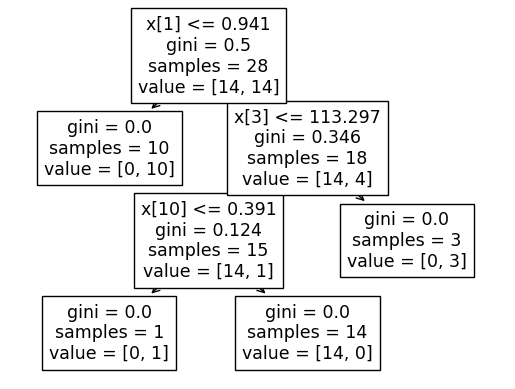

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

X = feature_df
y = label_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Modell testen
y_pred = clf.predict(X_test)

# Modell auswerten
print("Genauigkeit:", accuracy_score(y_test, y_pred))
print("Konfusionsmatrix:\n", confusion_matrix(y_test, y_pred))
print("Klassifikationsreport:\n", classification_report(y_test, y_pred))

# Baum visualisieren (optional)
plot_tree(clf)






Clustering

In [ ]:
from sklearn.cluster import KMeans

# Anzahl der gewünschten Cluster festlegen 
anzahl_cluster = 2  # Passe dies an deine Anforderungen an.

# Initialisierung des K-Means-Cluster-Algorithmus
kmeans = KMeans(n_clusters=anzahl_cluster, random_state=0)

# Clustering auf den Daten in 'feature_df' durchführen
cluster_labels = kmeans.fit_predict(feature_df)

# Berechnete Cluster zu jedem der Datenpunkte im Feature Dataframe zuordnungen
feature_df['Cluster'] = cluster_labels

# Gib das aktualisierte DataFrame mit Clusterzuordnungen aus.
#print(feature_df.head())
feature_df.columns


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Index(['acc_y_peak', 'acc_y_std_dev', 'acc_y_variance', 'acc_y_signal_energy',
       'acc_z_peak', 'acc_z_std_dev', 'acc_z_variance', 'acc_z_signal_energy',
       'gyro_x_peak', 'gyro_x_std_dev', 'gyro_x_variance',
       'gyro_x_signal_energy', 'Cluster'],
      dtype='object')

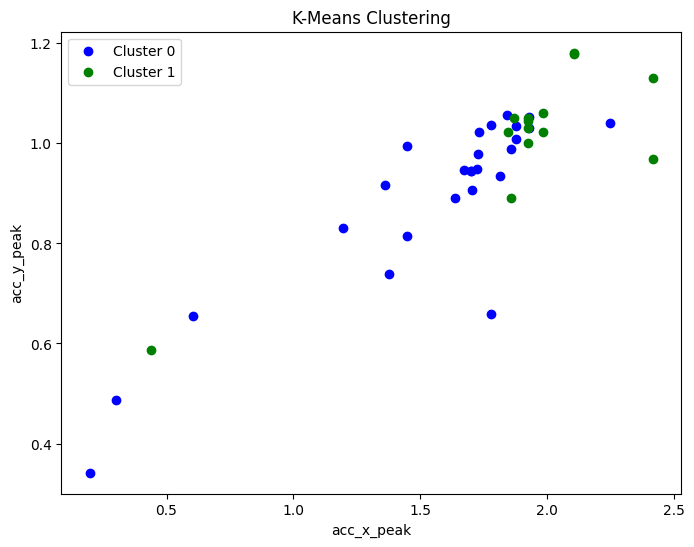

In [ ]:
# Visualisierung der Cluster
plt.figure(figsize=(8, 6))

# Erstelle eine Liste von Farben für die Cluster
farben = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Durchlaufen der Cluster und erstellen der Scatter-Plots für jeden Cluster
for cluster_id in range(anzahl_cluster):
    cluster_data = feature_df[feature_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['acc_y_peak'], cluster_data['acc_y_std_dev'], c=farben[cluster_id], label=f'Cluster {cluster_id}')
# Beschriftung des Diagramms
plt.xlabel('acc_x_peak')
plt.ylabel('acc_y_peak')
plt.title('K-Means Clustering')
plt.legend()

# Anzeigen des Scatter-Plots
plt.show()
